**author**: lukethompson@gmail.com<br>
**date**: 26 Feb 2017<br>
**language**: Python 3.5<br>
**conda enviroment**: emp-py3<br>
**license**: unlicensed<br>

## otu_trading_cards.ipynb

Generate LaTeX macros and figures for a 'trading card' for any given Deblur OTU (tag sequence).

### Settings and input files

In [1]:
import pandas as pd
import numpy as np
import biom
import wikipedia
import re
import os
import errno
import math
import matplotlib.pyplot as plt
import seaborn as sns
import empcolors
import GetV4Region
%matplotlib inline

In [2]:
# seaborn plot settings
sns.set(style='white', palette='muted', color_codes=True)
sns.set_context('talk', rc={"font.size":13,"axes.titlesize":13,"axes.labelsize":13})
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
# input
path_map = '~/emp/metadata-refine/emp_qiime_mapping_subset_2k.tsv'
path_biom = '~/emp/otu-tables/deblur/emp_deblur_90bp.subset_2k.rare_5000.biom'
path_otus = '~/emp/analyses-otus/otu_summary.emp_deblur_90bp.subset_2k.rare_5000.tsv'
path_rdp = '~/emp/analyses-otus/otu_seqs_top_500_prev_plus_top_specialized.emp_deblur_90bp.subset_2k.rare_5000.tsv'
obs_column = 'observations_deblur_100bp'
trim_length = 90   # 90, 100, 150
num_samples = 2000 # 2000 for 90bp, 1856 for 100bp, 975 for 150bp
rarefaction_depth = 5000
subset = '2k'

# output
path_output = '~/emp/analyses-otus'

In [4]:
# dataframe of colors
df_colors = pd.DataFrame.from_dict(empcolors.get_empo_cat_color(returndict=True), orient='index')
df_colors.sort_index(inplace=True)

### Functions

In [5]:
# get wikipedia entry for genus or higher (lowest taxonomic level that begins (position 3) with capital letter)
# lookup is commented out -- this function just gets the title for the OTU and its directory
def get_wikipedia(my_taxonomy):
    for level in reversed(my_taxonomy.split('; ')):
        if len(level) > 3:
            if level[3].isupper():
                title = level[3:]
                print(title)
                return('%s\tDid not look up Wikipedia page for %s.' % (title, title))
#                 try:
#                     entry = wikipedia.page(title)
#                     return('%s\t%s' % (title, entry.summary))
#                 except wikipedia.exceptions.DisambiguationError as e:
#                     return('%s\t%s has multiple options: %s' % (title, title, e.options))
#                 except wikipedia.exceptions.PageError as e:
#                     return('%s\t%s has no Wikipedia page.' % (title, title))
#                 break

In [6]:
# make directory if doesn't already exist
def make_directory(path):
    try:
        os.mkdir(path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise exc
        pass

In [7]:
# make dataframe of a given otu with metadata
def scatter_map(table, samples, seq):
    otu_count = table.data(id=seq, axis='observation')
    df_otu = pd.DataFrame(data=otu_count, index=samples, columns=['otu'])
    df_otu_map = pd.merge(df_map, df_otu, left_index=True, right_index=True)
    # must remove zero counts otherwise scatter plot is misleading
    df_otu_map.otu = [np.nan if x==0 else x for x in df_otu_map.otu]
    return(df_otu_map)

### Section 1: Read input tables

In [8]:
# read mapping file
df_map = pd.read_csv(path_map, sep='\t', index_col=0)
# read otu summary
df_otus = pd.read_csv(path_otus, sep='\t', index_col=0)
# read rdp taxonomy (index = sequence)
df_rdp = pd.read_csv(path_rdp, sep='\t', index_col=0)
df_rdp.fillna('', inplace=True)

In [9]:
# read biom table
table = biom.load_table(path_biom)

In [10]:
otus = table.ids(axis='observation')
samples = table.ids(axis='sample')

### Section 2: Make the OTU lists

#### Option 1: Top OTUs by num_samples

In [28]:
df_otus_top = df_otus.sort_values('num_samples', ascending=False).head(10)

In [29]:
df_otus_top[['sequence', 'num_samples', 'num_samples_frac', 'num_samples_rank',
            'total_obs', 'total_obs_rank', 'total_obs_frac', 'taxonomy']].to_csv('~/emp/analyses-otus/top10_prevalence.emp_deblur_90bp.subset_2k.rare_5000.tsv')

#### Option 2: Top OTUs by total_obs

In [11]:
df_otus_top = df_otus.sort_values('total_obs', ascending=False).head(10)

In [12]:
df_otus_top[['sequence', 'num_samples', 'num_samples_frac', 'num_samples_rank',
       'total_obs', 'total_obs_rank', 'total_obs_frac', 'taxonomy']].to_csv('~/emp/analyses-otus/top10_abundance.emp_deblur_90bp.subset_2k.rare_5000.tsv')

#### Option 3: Top specialized OTUs from otu_entropy.ipynb

In [23]:
top_entropy = [
    'TACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGACTTTTAAGTGAGATGTGAAATCCCCGAGCTTAAC',
    'TACGGAGGGTGCGAGCGTTAATCGGAATGACTGGGCGTAAAGGGCATGTAGGCGGATAATTAAGTTAGGTGTGAAAGCCCTGGGCTCAAC',
    'TACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGACTTTTAAGTGAGATGTGAAATCCCCGAGCTTAAC',
    'TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGCGCGAAAAGTCAGCGGTCAAAGTTCCGGGCTCAAC',
    'TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGGATATTAAGTCAGTCGTCAAAGCCTGTGGCTCAAC',
    'TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGATTGGAAAGTAGGGGGTGAAATCCCGGGGCTCAAC',
    'TACAGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGCTTTGCAAGTCGGGTGTGAAATCCCCAAGCTCAAC',
    'TACAGAGGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGTGTTGTAAGTCACCTGTGAAACCTCTAGGCTTAAC',
    'TACAGAGGGTGCAAGCGTTAATCGGATTTACTGGGCGTAAAGCGCGCGTAGGCGGTTAGATAAGTCGGATGTGAAAGCCCCGGGCTTAAC',
    'TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGCCTGATAAGTTGGATGTGAAAGCCCTGGGCTCAAC',
    'GACAGAGGAGGCGAGCGTTATCCGGAGTCATTGGGCGTAAAGGGTACGTAGGCGGCTAGTCAAGTCTGAGGTTAAAGACCACAGCTTAAC',
    'TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGCGCTCAAC',
    'TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGAAAAATAAGTCTAATGTGAAAGCCCTCGGCTTAAC',
    'GACGTAGGATCCAAGCGTTATCCGGAATTACTGGGCGTAAAGGGCGTGTAGGAGGTTGGGCAAGTCGGCCATGAAAGCTCCCGGCTCAAC',
    'TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGTTTATTAAGTCAGATGTGAAAGCCCCGGGCTTAAC'
]

In [24]:
df_otus_top = df_otus[df_otus['sequence'].isin(top_entropy)]

#### Option 4: OTUs matching to query 16S (e.g., Bacteroides)

In [16]:
for path in ['~/moi/sequences/RefSeq_16S/Bacteroides_coprocola_M16.NR_041278.fasta',
             '~/moi/sequences/RefSeq_16S/Bacteroides_dorei_175.NR_041351.fasta',
             '~/moi/sequences/RefSeq_16S/Bacteroides_intestinalis_341.NR_041307.fasta']:
    GetV4Region.GetV4(inputname=path, 
                  fprimer='GTGCCAGC[AC]GCCGCGGTAA',
                  rprimer='ATTAGA[AT]ACCC[CGT][AGT]GTAGTCC',
                  length=90,
                  remove_ambig=False,
                  keep_primers=False,
                  skip_reverse=False)

>NR_041278.1 Bacteroides coprocola strain M16 16S ribosomal RNA gene, partial sequence
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGACGGGAGATTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC
>NR_041351.1 Bacteroides dorei strain 175 16S ribosomal RNA gene, partial sequence
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC
>NR_041307.1 Bacteroides intestinalis strain 341 16S ribosomal RNA gene, partial sequence
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGATTATTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC


In [17]:
bacteroides = [
        'TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGACGGGAGATTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC',
        'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC',
        'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGATTATTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC',
    ]

In [18]:
set(bacteroides)

{'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC',
 'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGATTATTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC',
 'TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGACGGGAGATTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC'}

In [19]:
df_otus_top = df_otus[df_otus['sequence'].isin(bacteroides)]

##### TO DO: Add fasta name to df_otus_top so we can track the strains

### Section 3. Make the trading cards

#### Wikipedia (only using for title)

In [30]:
# add wikipedia summary
df_otus_top['wikipedia'] = df_otus_top['taxonomy'].apply(get_wikipedia)
df_otus_top['title'] = [value.split('\t')[0] for value in df_otus_top['wikipedia']]
df_otus_top['wikipedia'] = [value.split('\t')[1] for value in df_otus_top['wikipedia']]

Bacillus
Streptophyta
Bradyrhizobium
Arthrobacter
Acidobacteria-6
Enterobacteriaceae
Streptococcus
Pseudomonas
Rhodoplanes
Pseudomonas


In [31]:
# use only first OTU for testing purposes
#df_otus_top.iloc[[0]]

/Users/luke.thompson/miniconda3/envs/emp-py3/lib/python3.5/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/luke.thompson/miniconda3/envs/emp-py3/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/luke.thompson/miniconda3/envs/emp-py3/lib/python3.5/site-packages/pandas/core/series.py:2645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

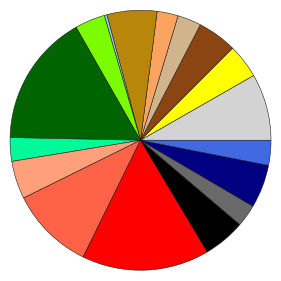

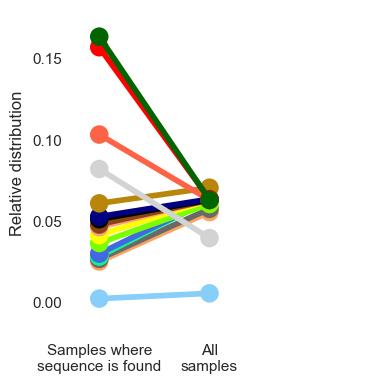

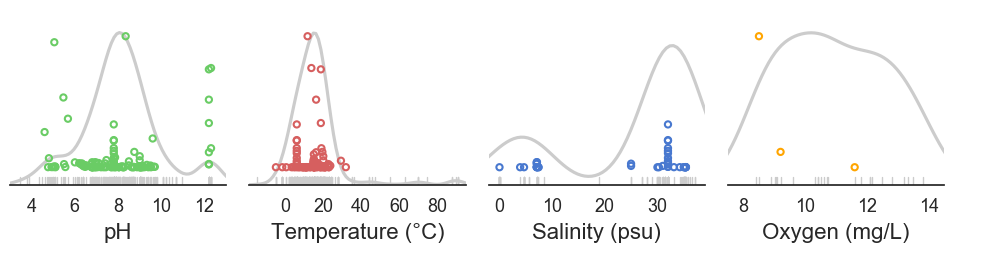

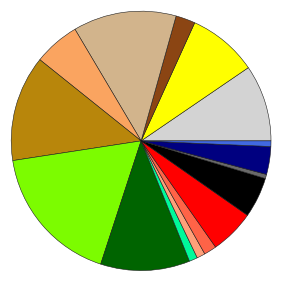

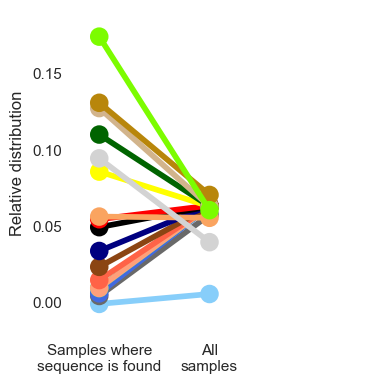

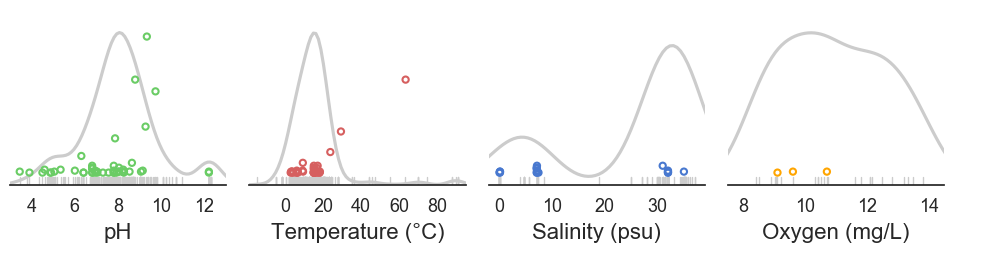

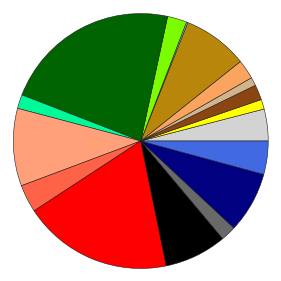

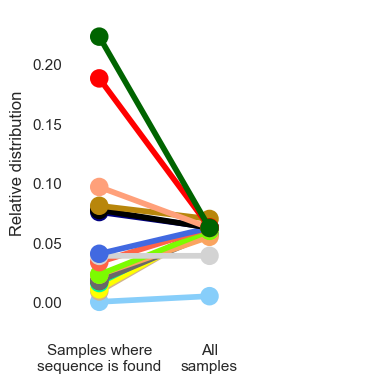

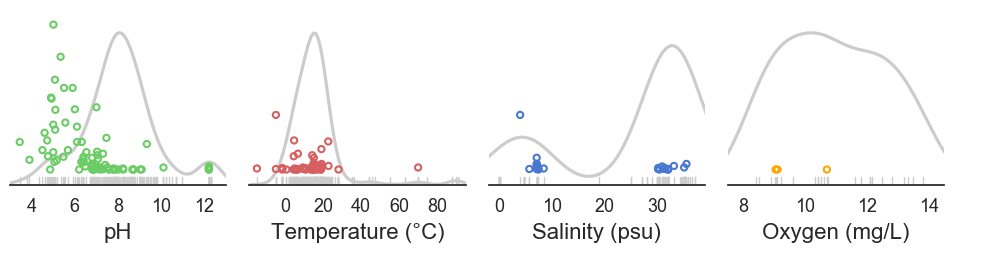

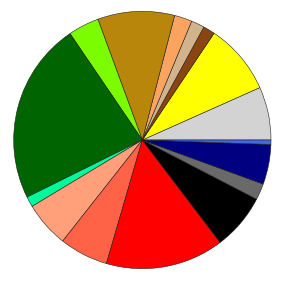

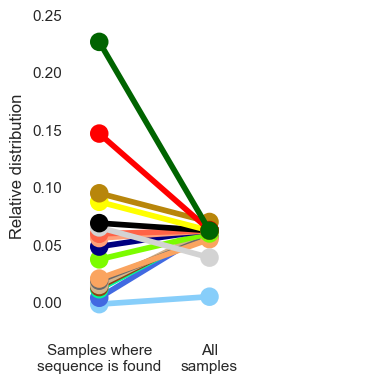

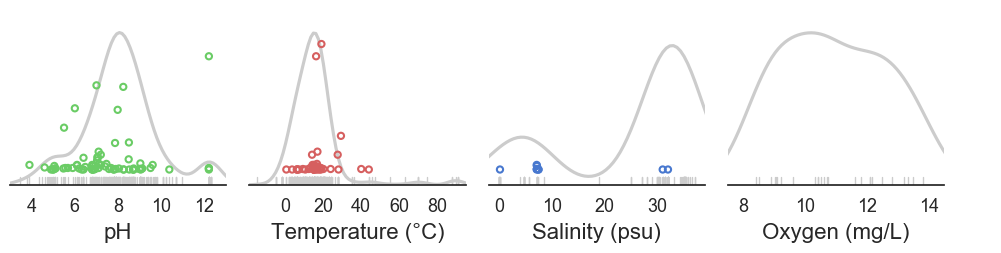

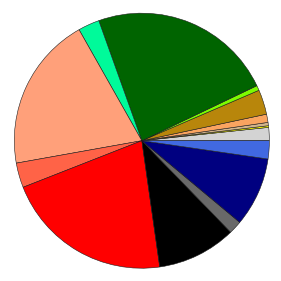

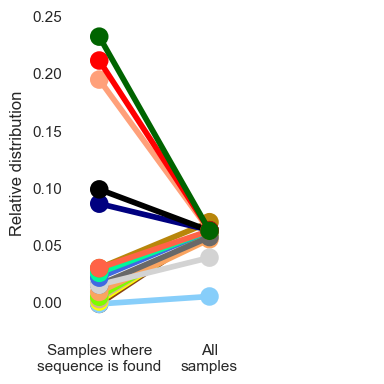

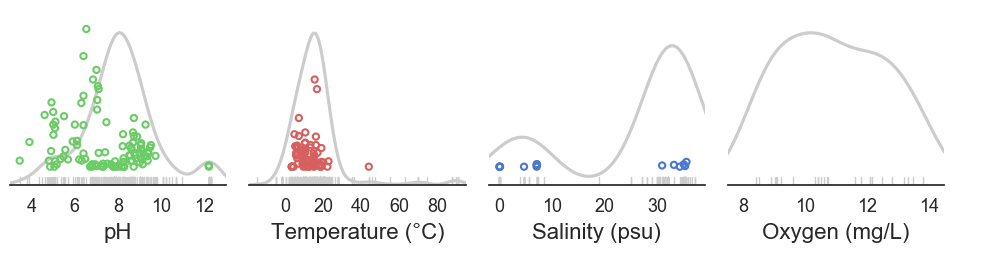

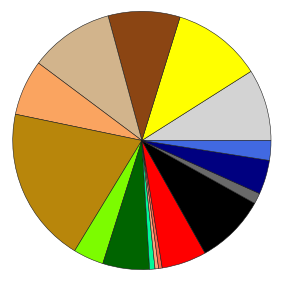

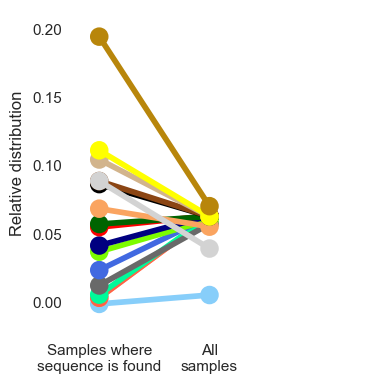

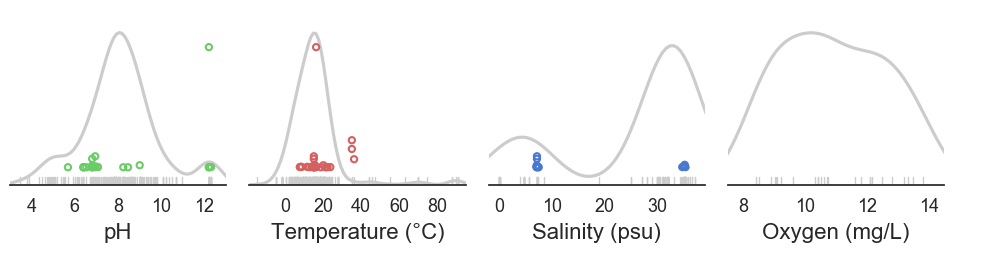

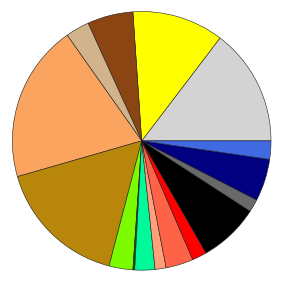

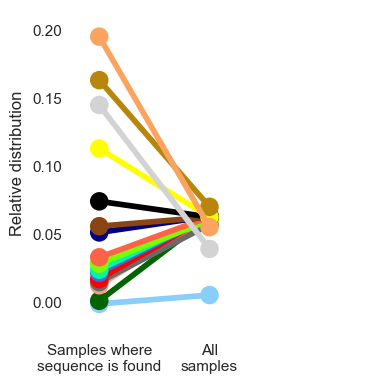

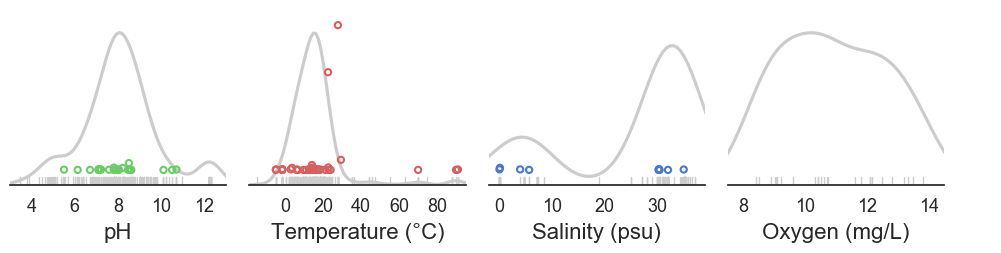

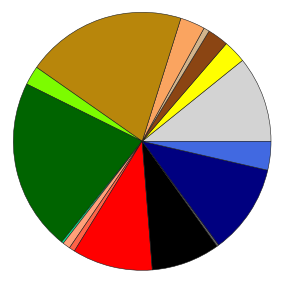

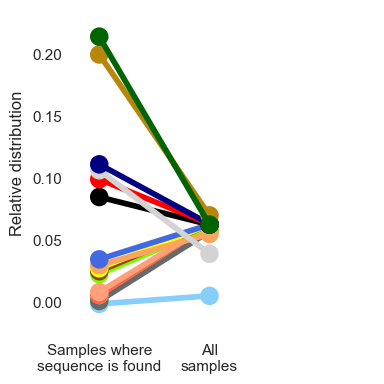

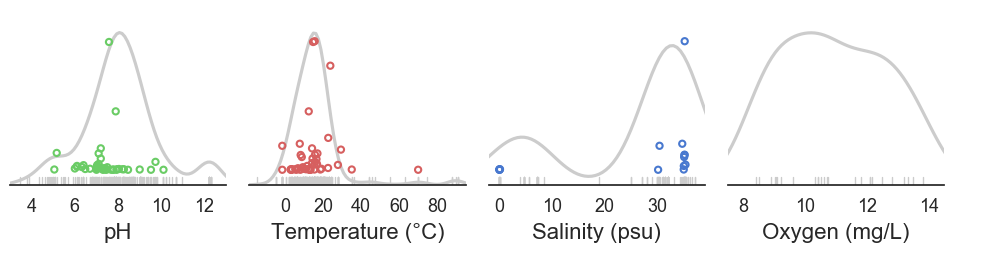

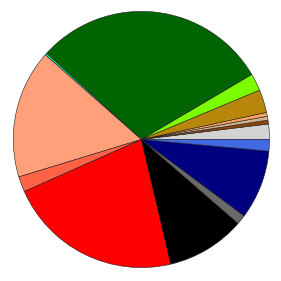

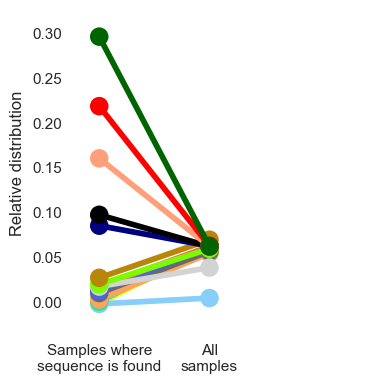

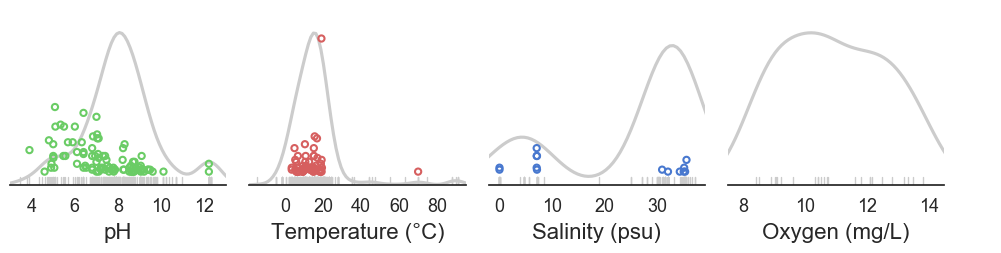

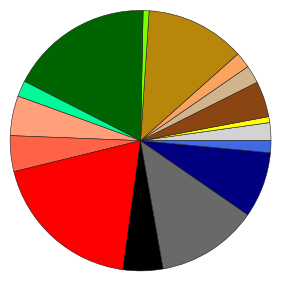

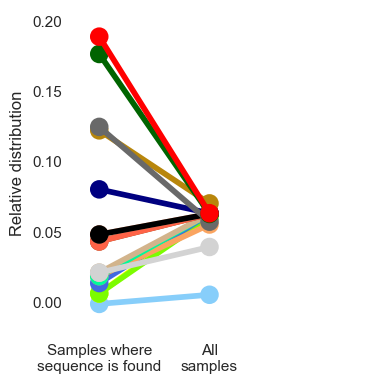

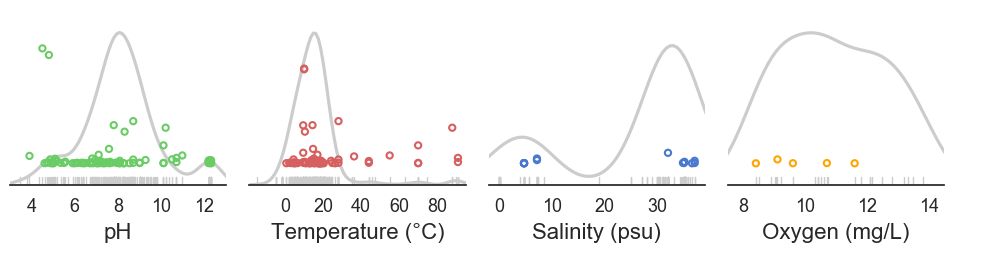

In [32]:
for index, row in df_otus_top.iterrows():
    
    # STORE THE RELEVANT VALUES
    sequence = row['sequence']
    taxonomy_gg = re.sub(r'_', r'\_', row['taxonomy'])
    try:
        df_rdp.loc[row['sequence']]
        taxonomy_rdp = re.sub(r'_', r'\_', df_rdp.loc[row['sequence']]['lineage_count'])
        species_1st_rdp = df_rdp.loc[row['sequence']]['species_1st_count']
        species_2nd_rdp = df_rdp.loc[row['sequence']]['species_2nd_count']
        species_3rd_rdp = df_rdp.loc[row['sequence']]['species_3rd_count']
    except:
        taxonomy_rdp = ''
        species_1st_rdp = ''
        species_2nd_rdp = ''
        species_3rd_rdp = ''
    wikipedia = row['wikipedia']
    wikipedia = re.sub(r'"', r'``', wikipedia)
    wikipedia = re.sub(u'\u201D', r"''", wikipedia) # need to replace unicode backward double quote
    title = row['title']
    prevalencePercent = row['num_samples_frac'] * 100
    prevalenceRank = str(row['num_samples_rank'])
    abundancePercent = row['total_obs_frac'] * 100
    abundanceRank = str(row['total_obs_rank'])
    numOTUs = str(df_otus.shape[0])
    trimLength = str(trim_length)
    numSamples = str(num_samples)
    rarefactionDepth = str(rarefaction_depth)

    # MAKE DIRECTORY
    make_directory('%s/card_%sbp_subset%s_rare%s_rank%s_%s' % (path_output, 
            trimLength, subset, rarefactionDepth, prevalenceRank, title))
    
    # CREATE MACROS FILE
    with open('%s/card_%sbp_subset%s_rare%s_rank%s_%s/macros.tex' % (path_output, 
            trimLength, subset, rarefactionDepth, prevalenceRank, title), 'w') as target:
        # SEQUENCE
        target.write(r'\def\sequence{')
        # first 50bp
        target.write(sequence[:50])
        # next 50bp
        target.write('\n')
        target.write(sequence[50:100])
        # next 50bp if > 100bp
        if len(sequence) > 100:
            target.write('\n')
            target.write(sequence[100:150])
        target.write('}\n')
        # TAXONOMY
        target.write(r'\def\taxonomyGG{')
        target.write(taxonomy_gg)
        target.write('}\n')
        target.write(r'\def\taxonomyRDP{')
        target.write(taxonomy_rdp)
        target.write('}\n')
        target.write(r'\def\speciesA{')
        target.write(species_1st_rdp)
        target.write('}\n')
        target.write(r'\def\speciesB{')
        target.write(species_2nd_rdp)
        target.write('}\n')
        target.write(r'\def\speciesC{')
        target.write(species_3rd_rdp)
        target.write('}\n')
        # WIKIPEDIA
        target.write(r'\def\wikipedia{')
        if len(wikipedia) > 650:
           target.write(wikipedia[:650])
           target.write('...')
        else:
           target.write(wikipedia)
        target.write('}\n')
        # PREVALENCE
        target.write(r'\def\prevalencePercent{')
        target.write('{:0.2f}'.format(prevalencePercent))
        target.write('}\n')
        target.write(r'\def\prevalenceRank{')
        target.write(prevalenceRank)
        target.write('}\n')
        # ABUNDANCE
        target.write(r'\def\abundancePercent{')
        target.write('{:0.3f}'.format(abundancePercent))
        target.write('}\n')
        target.write(r'\def\abundanceRank{')
        target.write(abundanceRank)
        target.write('}\n')
        # METHODS/MISC
        target.write(r'\def\numOTUs{')
        target.write(numOTUs)
        target.write('}\n')
        target.write(r'\def\trimLength{')
        target.write(trimLength)
        target.write('}\n')
        target.write(r'\def\numSamples{')
        target.write(numSamples)
        target.write('}\n')
        target.write(r'\def\rarefactionDepth{')
        target.write(rarefactionDepth)
        target.write('}\n')
        
    # DRAW FIGURES
    
    # EMPO_3 PIE CHART OF PRESENCE/ABSENCE
    # value counts of empo_3 categories of samples OTU is found in
    empo3_count = df_map.loc[row['list_samples'].split(',')]['empo_3'].value_counts()
    
    # value counts of empo_3 categories of all samples
    empo3_count_all = df_map['empo_3'].value_counts()
    empo3_frac_all = pd.DataFrame(empo3_count_all / empo3_count_all.sum())
    
    # concat colors with counts and then remove zero values
    df_empo3 = pd.concat([df_colors, empo3_count], axis=1)
    df_empo3.columns = ['color', 'count']
    df_empo3_nonzero = df_empo3[df_empo3['count'] > 0]
    
    # draw pie chart
    fig = plt.figure(figsize=(4,4))
    fig.set_size_inches(3, 3)
    patches, text = plt.pie(df_empo3_nonzero['count'], 
                            #labels=df_empo3_nonzero.index, 
                            labels=None, 
                            colors=df_empo3_nonzero['color'], 
                            startangle=0)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('%s/card_%sbp_subset%s_rare%s_rank%s_%s/pie.pdf' % (path_output, 
            trimLength, subset, rarefactionDepth, prevalenceRank, title))
    
    # EMPO_3 POINT PLOT OF PRESENCE/ABSENCE
    # value counts of empo3 counts in subset of samples
    vc_empo3_subset = df_map[df_map['observations_deblur_100bp'] >= 5000]['empo_3'].value_counts()
    df_empo3_nonzero.loc[:, 'count_all'] = vc_empo3_subset[df_empo3_nonzero.index] * 0.5
    
    # normalize counts to total
    df_empo3_nonzero.loc[:, 'count_all_norm'] = df_empo3_nonzero['count_all'] / df_empo3_nonzero['count_all'].sum()
    df_empo3_nonzero.loc[:, 'count_norm'] = df_empo3_nonzero['count'] / df_empo3_nonzero['count'].sum()

    df_empo3_nonzero = pd.merge(df_empo3_nonzero, empo3_frac_all, left_index=True, right_index=True, how='outer')
    df_empo3_nonzero = pd.merge(df_colors, df_empo3_nonzero, left_index=True, right_index=True)
    df_empo3_nonzero.drop('color', axis=1, inplace=True)
    df_empo3_nonzero.columns = ['color', 'count_all', 'count', 'count_all_norm', 'count_norm', 'empo_frac']
    df_empo3_nonzero.fillna(0, inplace=True)
    
    # add empo column and reorder columns
    df_empo3_nonzero.loc[:, 'empo'] = df_empo3_nonzero.index
    df_empo3_nonzero = df_empo3_nonzero[['empo', 'color', 'count_all', 'count', 'count_all_norm', 'count_norm', 'empo_frac']]
    
    # melt to format that is plot-able
    df_empo3_nonzero_melted = pd.melt(df_empo3_nonzero, id_vars=['empo', 'color'], 
                                      value_vars=['count_norm', 'empo_frac'])
    df_empo3_nonzero_melted.sort_values('variable', ascending=False, inplace=True)
    df_empo3_nonzero_melted.sort_values(by=['variable', 'value'], ascending=[True, True], inplace=True)
    
    # point plot
    #fig, ax = plt.subplots(figsize=(5,4))
    fig, ax = plt.subplots(figsize=(4,4))
    sns.pointplot(x='variable', y='value', hue='empo', 
                  data=df_empo3_nonzero_melted, 
                  palette=df_empo3_nonzero_melted['color'])
    plt.legend().set_visible(False)

    # labels
    #for empo in df_empo3_nonzero.index:
    #    mysize = 8+40*df_empo3_nonzero.loc[empo,'count_norm']
    #    if mysize > 16:
    #        mysize = 16
    #    plt.text(1.08, df_empo3_nonzero.loc[empo,'count_norm'], 
    #             df_empo3_nonzero.loc[empo,'empo'], 
    #             fontsize=mysize, va='center')

    plt.axis([-0.1, 2.5, df_empo3_nonzero['count_norm'].max()*-0.05, df_empo3_nonzero['count_norm'].max()*1.1])
    plt.box('off')
    plt.xticks([0, 1], ('Samples where\nsequence is found', 'All\nsamples'))
    ax.tick_params(labelsize=11)
    plt.xlabel('')
    plt.ylabel('Relative distribution', fontsize=12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    sns.despine(offset=10, trim=True)
    plt.tight_layout(pad=1)
    plt.savefig('%s/card_%sbp_subset%s_rare%s_rank%s_%s/point.pdf' % (path_output, 
        trimLength, subset, rarefactionDepth, prevalenceRank, title))
    
    # ENVIRONMENTAL PARAMETER DISTRIBUTION PLOTS OF PRESENCE/ABSENCE
    # get ph values of samples OTU is found in
    ph_values = df_map.loc[row['list_samples'].split(',')]['ph']
    ph_values.dropna(inplace=True)
    all_ph_values = df_map[df_map[obs_column] >= 5000]['ph']
    all_ph_values.dropna(inplace=True)
    
    # get temperature values of samples OTU is found in
    temp_values = df_map.loc[row['list_samples'].split(',')]['temperature_deg_c']
    temp_values.dropna(inplace=True)
    all_temp_values = df_map[df_map[obs_column] >= 5000]['temperature_deg_c']
    all_temp_values.dropna(inplace=True)

    # get salinity values of samples OTU is found in
    sal_values = df_map.loc[row['list_samples'].split(',')]['salinity_psu']
    sal_values.dropna(inplace=True)
    all_sal_values = df_map[df_map[obs_column] >= 5000]['salinity_psu']
    all_sal_values.dropna(inplace=True)

    # get oxygen values of samples OTU is found in
    ox_values = df_map.loc[row['list_samples'].split(',')]['oxygen_mg_per_l']
    ox_values.dropna(inplace=True)
    all_ox_values = df_map[df_map[obs_column] >= 5000]['oxygen_mg_per_l']
    all_ox_values.dropna(inplace=True)

    # get actual counts per sample
    df_otu_map = scatter_map(table, samples, sequence)
    
    # draw dist plots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 2.5))
    sns.despine(left=True)
    
    # ph
    if ph_values.shape[0] > 1:
        axes[0].scatter(df_otu_map.ph, df_otu_map.otu, facecolors='none', edgecolors='g', linewidth=1.5)
    ax0 = axes[0].twinx()
    sns.distplot(all_ph_values, hist=False, rug=True, kde=True, color='0.8', ax=ax0, axlabel='pH')
    axes[0].set_zorder(ax0.get_zorder()+1)
    axes[0].patch.set_visible(False)
    ax0.axis('off')
    axes[0].set_xlabel('pH', fontsize=16)

    # temperature
    if temp_values.shape[0] > 1:
        axes[1].scatter(df_otu_map.temperature_deg_c, df_otu_map.otu, facecolors='none', edgecolors='r', linewidth=1.5)
    ax1 = axes[1].twinx()
    sns.distplot(all_temp_values, hist=False, rug=True, kde=True, color='0.8', ax=ax1, axlabel='Temperature (°C)')
    axes[1].set_zorder(ax1.get_zorder()+1)
    axes[1].patch.set_visible(False)
    ax1.axis('off')
    axes[1].set_xlabel('Temperature (°C)', fontsize=16)

    # salinity
    if sal_values.shape[0] > 1:
        axes[2].scatter(df_otu_map.salinity_psu, df_otu_map.otu, facecolors='none', edgecolors='b', linewidth=1.5)
    ax2 = axes[2].twinx()
    sns.distplot(all_sal_values, hist=False, rug=True, kde=True, color='0.8', ax=ax2, axlabel='Salinity (psu)')
    axes[2].set_zorder(ax2.get_zorder()+1)
    axes[2].patch.set_visible(False)
    ax2.axis('off')
    axes[2].set_xlabel('Salinity (psu)', fontsize=16)

    # oxygen
    if ox_values.shape[0] > 1:
        axes[3].scatter(df_otu_map.oxygen_mg_per_l, df_otu_map.otu, facecolors='none', edgecolors='orange', linewidth=1.5)
    ax3 = axes[3].twinx()
    sns.distplot(all_ox_values, hist=False, rug=True, kde=True, color='0.8', ax=ax3)
    axes[3].set_zorder(ax3.get_zorder()+1)
    axes[3].patch.set_visible(False)
    ax3.axis('off')
    axes[3].set_xlabel('Oxygen (mg/L)', fontsize=16)
    
    axes[0].set_xlim([3, 13])   #ph
    axes[1].set_xlim([-19, 95]) #temperature
    axes[2].set_xlim([-2, 39])  # salinity
    axes[2].set_xticks([0, 10, 20, 30])
    axes[3].set_xlim([7.5, 14.5]) #temperature
    axes[3].set_xticks([8, 10, 12, 14])    
    
    ymin = min([axes[0].get_ylim()[0], axes[1].get_ylim()[0], axes[2].get_ylim()[0], axes[3].get_ylim()[0]])*0.6
    ymax = max([axes[0].get_ylim()[1], axes[1].get_ylim()[1], axes[2].get_ylim()[1], axes[3].get_ylim()[1]])
    axes[0].set_ylim([ymin, ymax])
    axes[1].set_ylim([ymin, ymax])
    axes[2].set_ylim([ymin, ymax])
    axes[3].set_ylim([ymin, ymax])
    
    ax0.set_ylim([0, 0.33])
    ax1.set_ylim([0, 0.052])
    ax2.set_ylim([0, 0.062])
    ax3.set_ylim([0, 0.202])
    
    plt.setp(axes, yticks=[])

    plt.tight_layout(pad=0.5, w_pad=-1.5)
    plt.savefig('%s/card_%sbp_subset%s_rare%s_rank%s_%s/envparams.pdf' % (path_output, 
                trimLength, subset, rarefactionDepth, prevalenceRank, title))